# Anlysis for figure 3

## imports & installations

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
import os
from itertools import groupby
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve
from sklearn import metrics
import scipy

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
warnings.simplefilter("ignore")

sys.path.append(os.path.abspath('../..'))

import analysis.calc_single_cell_properties as calculator 
import analysis.calc_auc_over_time as auc_calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
import model_layer.utils as model_utils
from configuration import consts, params

## data loading - differentiation scores dataframes

In [65]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [66]:
scores_df_s3 = calculator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.vid_info_dict["3"]['actin_path'])
scores_df_s2 = calculator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.vid_info_dict["2"]['actin_path'])
scores_df_s5 = calculator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.vid_info_dict["5"]['actin_path'])
scores_df_s1 = calculator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.vid_info_dict["1"]['actin_path'])

## Cellular properties overview

the displayed data: 

S3 video, (Erki, 211212_CD7_ERK_P38), S2 video, (DMSO, 211212_CD7_ERK_P38), S6 video, (Erki + P38, 211212_CD7_ERK_P38), S8 video, (P38, 211212_CD7_ERK_P38)  
as the test set data. the scores are based on a model that was trained on videos s1 (DMSO,211006_CD7_DMSO_ERKi) & s5 (ERKi, 211006_CD7_DMSO_ERKi).
The followiing displayed trackes are *all* the manually-tracked cells.

In [7]:
def plot_property_over_time(properties_df_lst, features_list, time=(0,25)):
    sns.set_style("whitegrid")
    dfs = list(map(lambda x: x[0], properties_df_lst))
    labels = list(map(lambda x: x[1], properties_df_lst))
    colors = list(map(lambda x: x[2], properties_df_lst))

    tot = len(features_list)
    cols = 2
    rows = tot // cols
    if tot % cols != 0:
        rows += 1
    position = range(1, tot + 1)
    fig = plt.figure(1, figsize=(14,14))

    for k in range(tot):
        f = features_list[k]
        ax = fig.add_subplot(rows, cols, position[k])
        for df, label, color in zip(dfs, labels, colors):   

            df = df[(df["time"]>= time[0]) & (df["time"]< time[1])]
            df = df.sort_values("time")
            mean = round(df.dropna(subset=[f]).groupby("time")[f].mean(), 2).rolling(1).mean()
            std = round(df.dropna(subset=[f]).groupby("time")[f].std(), 2).rolling(1).mean()
            ax.plot(mean, color=color, label=label)
            plt.fill_between(df["time"].unique()[:len(mean)], mean - std, mean + std, alpha=0.4, color=color, label=label)
            
            ax.axvspan(6, 13, alpha=0.3, color='lightgray')
            ax.axvline(6, color='gray', linestyle='dashed')
            ax.axvline(13, color='gray', linestyle='dashed')
            
            ax.set_ylabel(f"{f}")
            ax.set_xlabel(f"time")
            ax.set_title(f'{f} over time')
            ax.grid(False)
            ax.legend()
            
    plt.savefig(consts.storage_path + f"eps_figs/property_over_time {str(labels)}.eps", format="eps")

time = (4,15)  
features_list = ["local density", "speed", "mean", "persistence"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


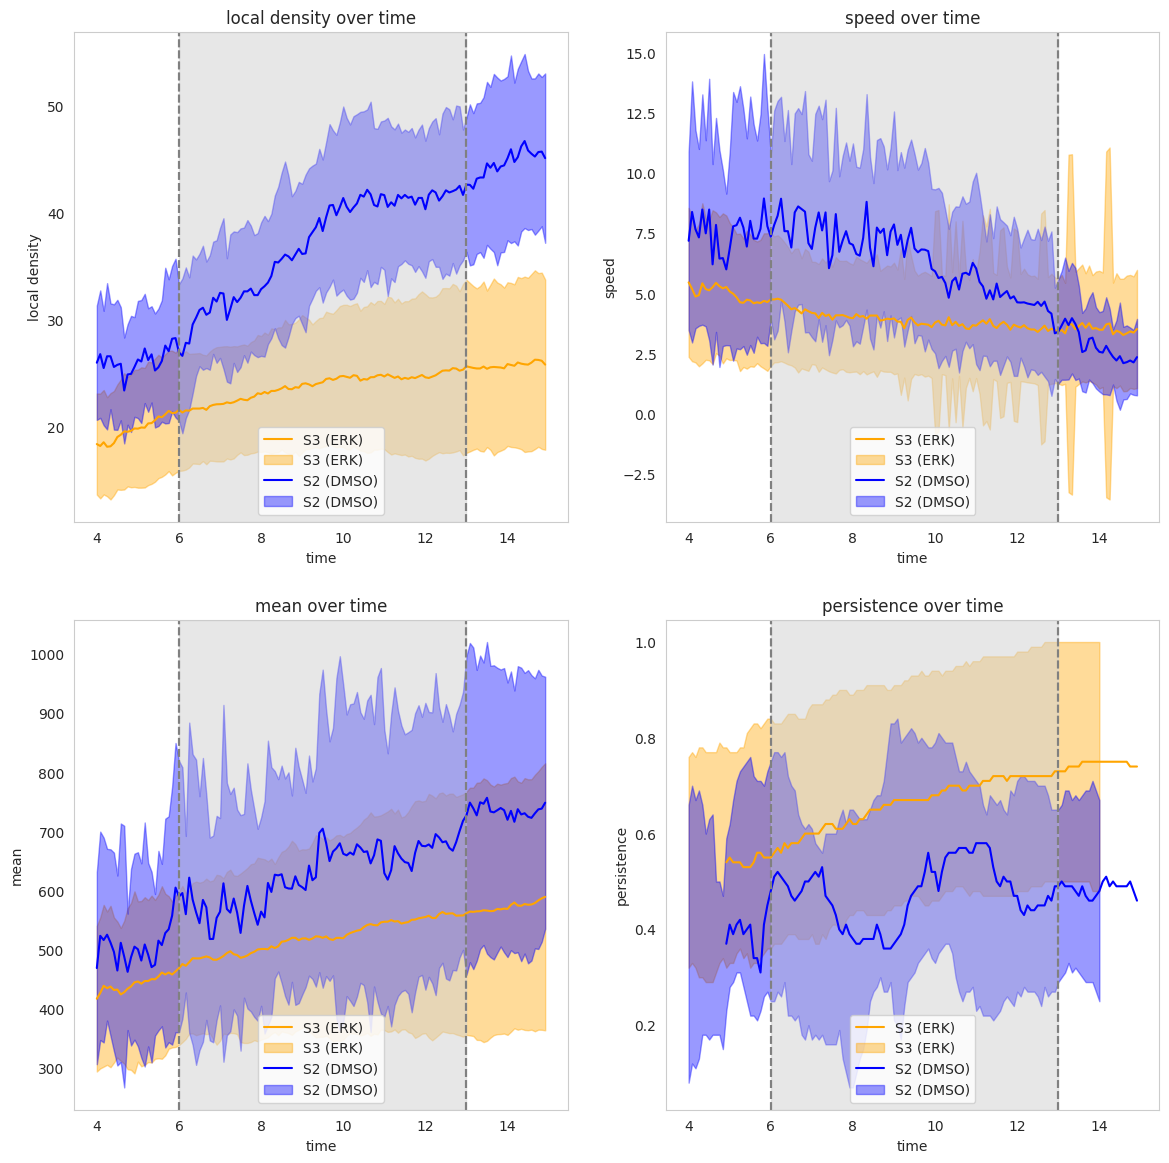

In [8]:
data = [(scores_df_s3, "S3 (ERK)","orange") ,(scores_df_s2, "S2 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


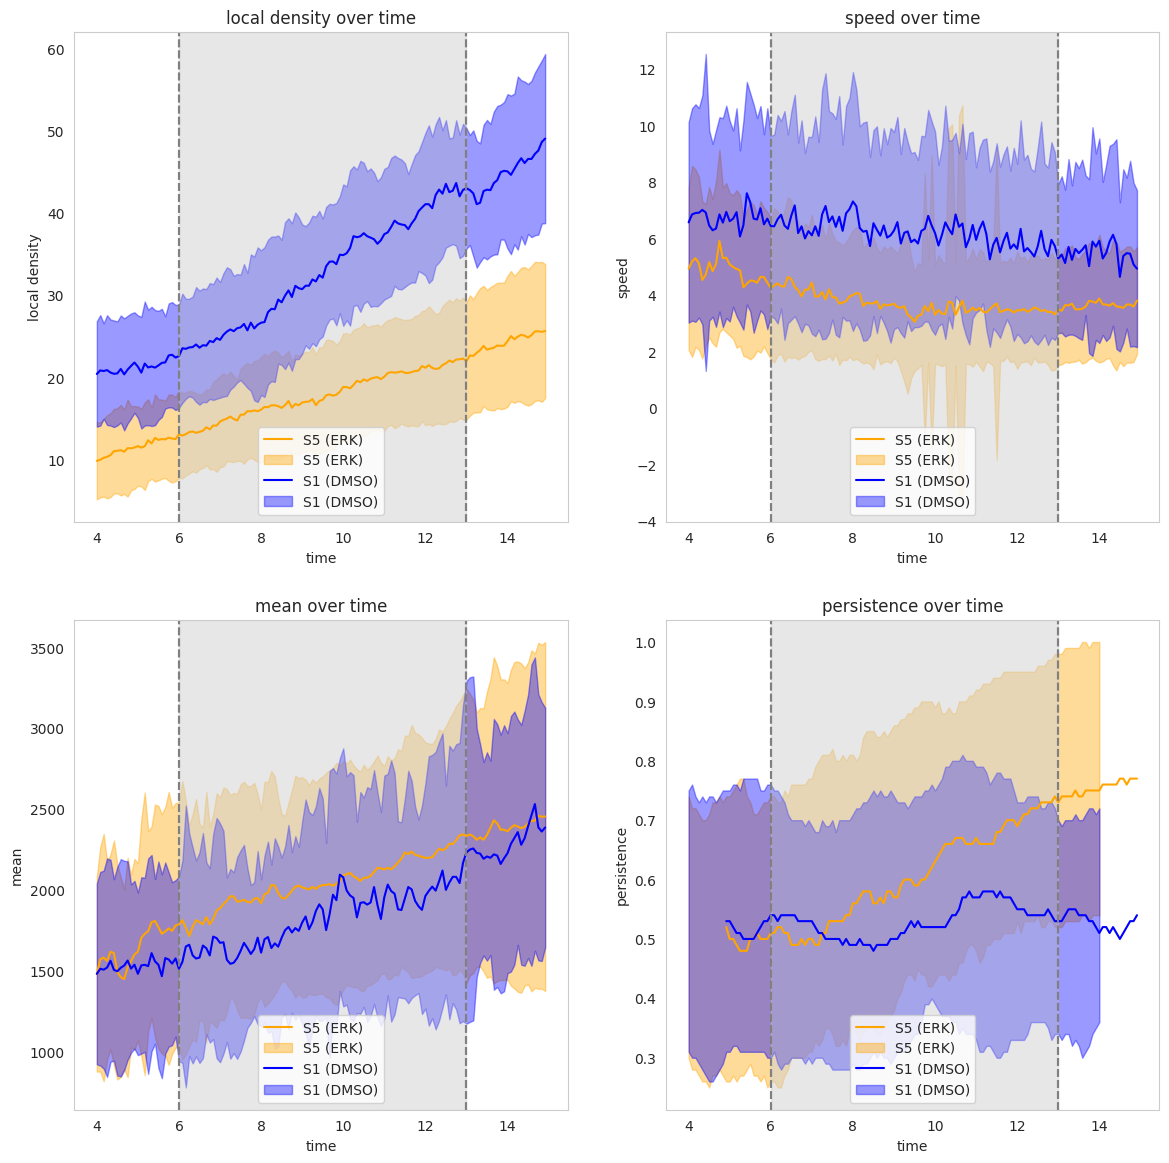

In [9]:
data = [(scores_df_s5, "S5 (ERK)","orange") ,(scores_df_s1, "S1 (DMSO)", "blue")]
plot_property_over_time(data, features_list, time=time)

the displayed data: 

S1 video, (DMSO,211006_CD7_DMSO_ERKi), S5 video, (Erki,211006_CD7_DMSO_ERKi)
as the test set data. the scores are based on a model that was trained on videos S3 (Erki, 211212_CD7_ERK_P38) & S2 (DMSO, 211212_CD7_ERK_P38).
The followiing displayed trackes are *all* the manually-tracked cells.

In [257]:
from sklearn.preprocessing import StandardScaler

def create_one_feature_df(data, target, features_lst, arg_scaler=None):
    data = data.sort_values("time")
    cols = features_lst.copy()
    cols.extend(["Spot frame", "Spot track ID"])
    df = data[cols]        
    for f in features_lst:        
        data_lst = df.groupby(['Spot track ID'])[f].apply(lambda x: list(x.rolling(30).mean()))
        df[f'moving_{f}'] = df.groupby(['Spot track ID'])['Spot track ID'].transform(lambda x: data_lst[x.iloc[0]])
        
        if arg_scaler:
            scaler =  StandardScaler()
            df[f'moving_{f}'] = scaler.fit_transform(np.array(df[f].values).reshape(-1, 1))
    df["target"] = target
    return df

def create_rf(dir_path, features_lst, cols, train_con, train_dif, test_con, test_dif, scaler):    
    df_train_con = create_one_feature_df(train_con, 0, features_lst, scaler).dropna(subset=cols)
    df_test_con = create_one_feature_df(test_con, 0, features_lst, scaler).dropna(subset=cols)
    df_test_dif = create_one_feature_df(test_dif, 1, features_lst, scaler).dropna(subset=cols)
    df_train_dif = create_one_feature_df(train_dif, 1, features_lst, scaler).dropna(subset=cols)
    
    train = model_utils.concat_dfs(df_train_dif[cols], df_train_con[cols], diff_t_window=params.diff_window, con_t_windows=params.con_window)
    test = model_utils.concat_dfs(df_test_dif[cols], df_test_con[cols], diff_t_window=params.diff_window, con_t_windows=params.con_window)

    X_train, y_train = pd.DataFrame(train.drop(columns=['Spot frame', 'Spot track ID', 'target'])), train["target"]
    X_test, y_test = pd.DataFrame(test.drop(columns=['Spot frame', 'Spot track ID', 'target'])), test["target"]
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    auc = utils.evaluate_model(clf, X_test, pd.DataFrame(y_test), features_lst, None, None, plot_auc_over_t=False)    
    data_utils.save_data(dir_path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, clf=clf)
    
    return [df_test_con, df_test_dif, clf, auc]

In [261]:
# pre_compute_properties_path = consts.intensity_model_path + "S%s_properties_MeanOpticalFlowReg_.pkl"

# props_s3 = pickle.load(open(pre_compute_properties_path % (1, 5 , 3), 'rb'))
# props_s2 = pickle.load(open(pre_compute_properties_path % (1, 5 , 2), 'rb'))
# props_s5 = pickle.load(open(pre_compute_properties_path % (1, 5 , 5), 'rb'))
# props_s1 = pickle.load(open(pre_compute_properties_path % (1, 5 , 1), 'rb'))

# props_s3["local density"] = props_s3["local_density"]
# props_s2["local density"] = props_s2["local_density"]
# props_s1["local density"] = props_s1["local_density"]
# props_s5["local density"] = props_s5["local_density"]

['local density']
size of diff_df:  (282, 3)
size of con_df:  (511, 3)
size of diff_df:  (590, 3)
size of con_df:  (191, 3)
Evaluation metrics for ['local density'] based model, tested on videos (sNone, sNone):
accuracy: 0.563
specificity: 0.895
sensitivity (recall): 0.456
precision: 0.931
AUC: 0.676


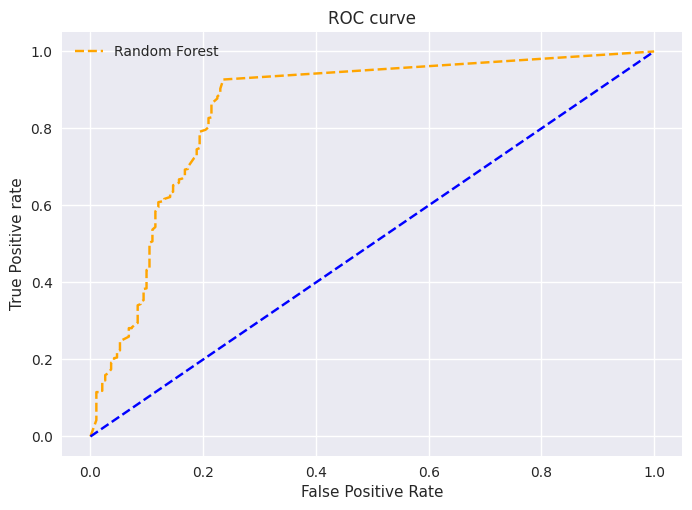

size of diff_df:  (590, 3)
size of con_df:  (191, 3)
size of diff_df:  (282, 3)
size of con_df:  (511, 3)
Evaluation metrics for ['local density'] based model, tested on videos (sNone, sNone):
accuracy: 0.622
specificity: 0.423
sensitivity (recall): 0.982
precision: 0.484
AUC: 0.702


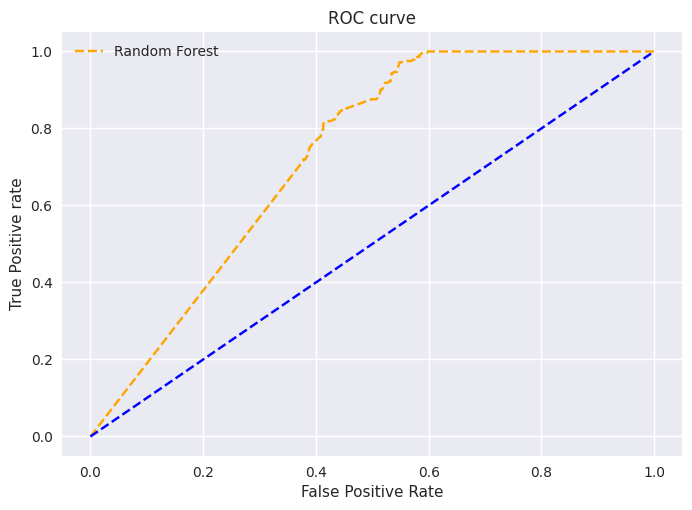

['speed']
size of diff_df:  (280, 3)
size of con_df:  (501, 3)
size of diff_df:  (587, 3)
size of con_df:  (188, 3)
Evaluation metrics for ['speed'] based model, tested on videos (sNone, sNone):
accuracy: 0.526
specificity: 0.665
sensitivity (recall): 0.482
precision: 0.818
AUC: 0.574


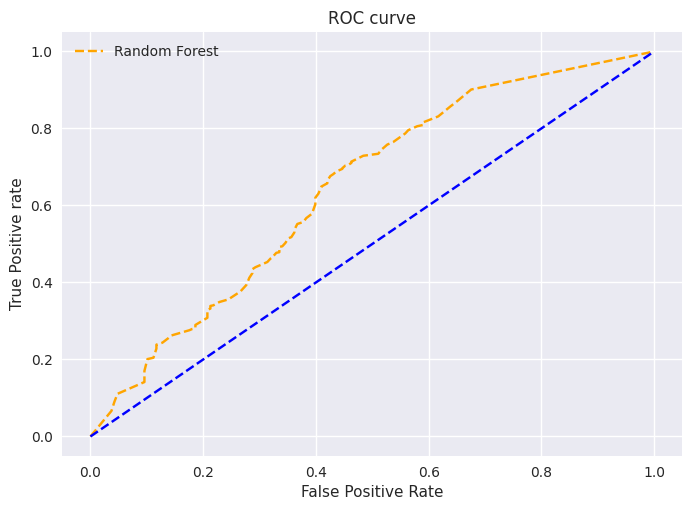

size of diff_df:  (587, 3)
size of con_df:  (188, 3)
size of diff_df:  (280, 3)
size of con_df:  (501, 3)
Evaluation metrics for ['speed'] based model, tested on videos (sNone, sNone):
accuracy: 0.529
specificity: 0.379
sensitivity (recall): 0.796
precision: 0.418
AUC: 0.588


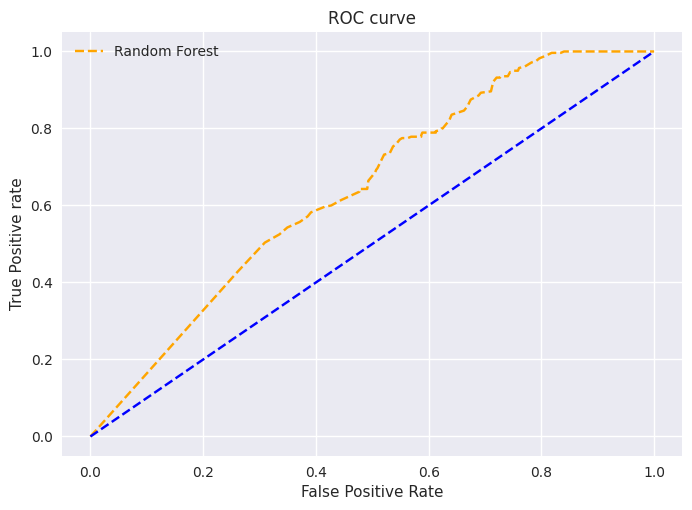

['mean']
size of diff_df:  (259, 3)
size of con_df:  (441, 3)
size of diff_df:  (474, 3)
size of con_df:  (189, 3)
Evaluation metrics for ['mean'] based model, tested on videos (sNone, sNone):
accuracy: 0.285
specificity: 1.0
sensitivity (recall): 0.0
precision: 0.0
AUC: 0.5


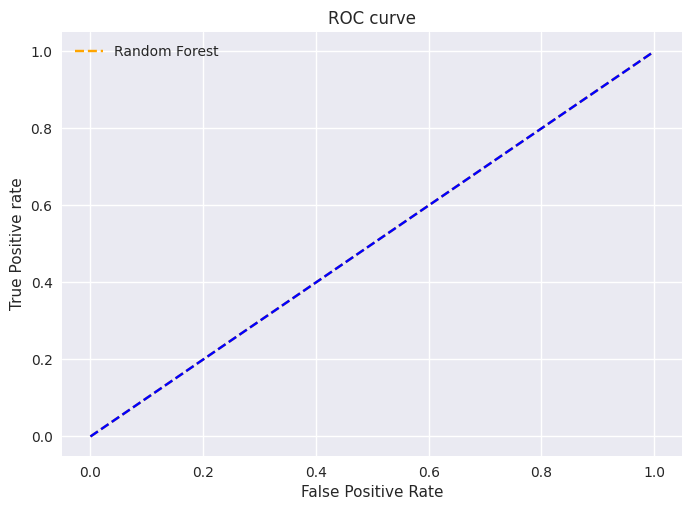

size of diff_df:  (474, 3)
size of con_df:  (189, 3)
size of diff_df:  (259, 3)
size of con_df:  (441, 3)
Evaluation metrics for ['mean'] based model, tested on videos (sNone, sNone):
accuracy: 0.477
specificity: 0.172
sensitivity (recall): 0.996
precision: 0.414
AUC: 0.584


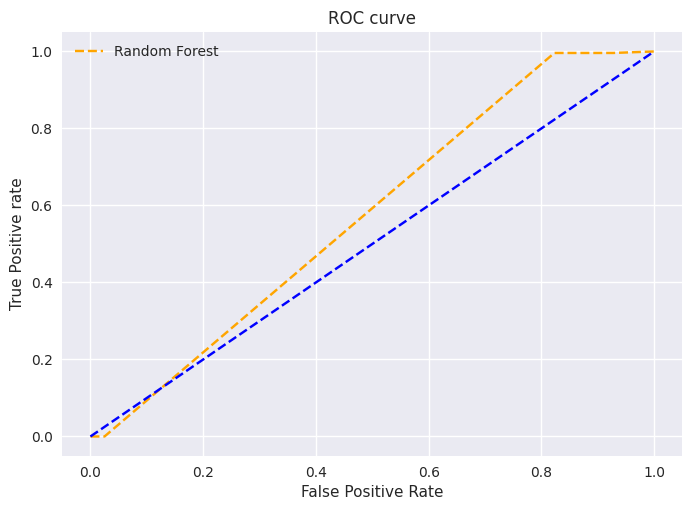

['persistence']
size of diff_df:  (91, 3)
size of con_df:  (157, 3)
size of diff_df:  (415, 3)
size of con_df:  (85, 3)
Evaluation metrics for ['persistence'] based model, tested on videos (sNone, sNone):
accuracy: 0.638
specificity: 0.882
sensitivity (recall): 0.588
precision: 0.961
AUC: 0.735


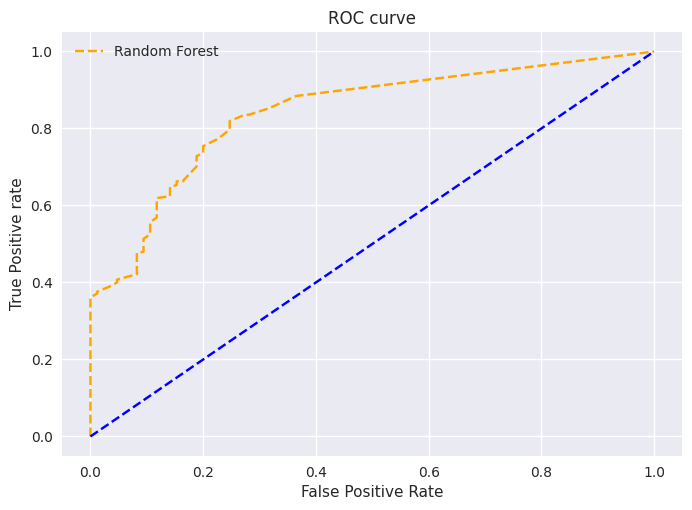

size of diff_df:  (415, 3)
size of con_df:  (85, 3)
size of diff_df:  (91, 3)
size of con_df:  (157, 3)
Evaluation metrics for ['persistence'] based model, tested on videos (sNone, sNone):
accuracy: 0.54
specificity: 0.338
sensitivity (recall): 0.89
precision: 0.438
AUC: 0.614


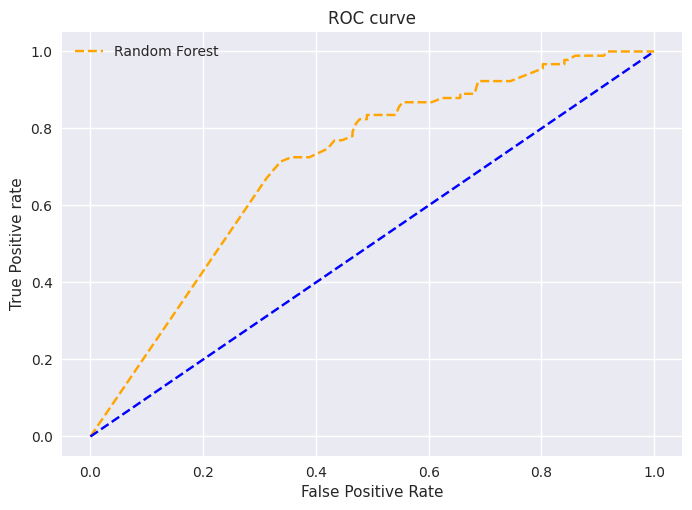

['speed', 'mean', 'persistence', 'local density']
size of diff_df:  (83, 6)
size of con_df:  (128, 6)
size of diff_df:  (340, 6)
size of con_df:  (84, 6)
Evaluation metrics for ['speed', 'mean', 'persistence', 'local density'] based model, tested on videos (sNone, sNone):
accuracy: 0.833
specificity: 1.0
sensitivity (recall): 0.791
precision: 1.0
AUC: 0.896


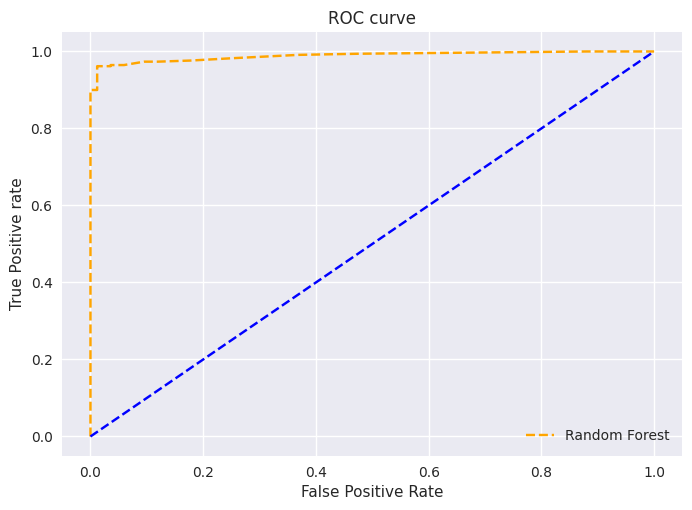

size of diff_df:  (340, 6)
size of con_df:  (84, 6)
size of diff_df:  (83, 6)
size of con_df:  (128, 6)
Evaluation metrics for ['speed', 'mean', 'persistence', 'local density'] based model, tested on videos (sNone, sNone):
accuracy: 0.82
specificity: 0.703
sensitivity (recall): 1.0
precision: 0.686
AUC: 0.852


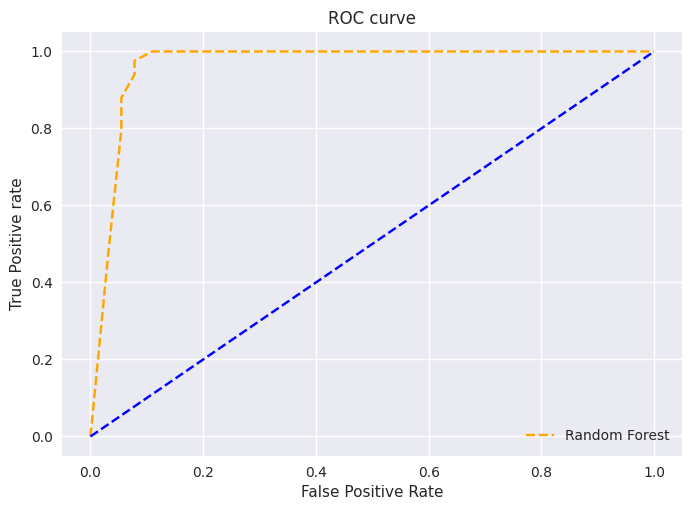

<Figure size 800x550 with 0 Axes>

In [267]:
def run_clf_model(features_lst, scaler, avg_score=False):
    cols = [f'moving_{f}' for f in features_lst]
    cols.extend([ "Spot frame", "Spot track ID"])
    os.makedirs(consts.storage_path + "simple_classifiers", exist_ok=True)
    for con_train_n, diff_train_n, con_test_n, diff_test_n in [("s1", "s5", "s2", "s3"), ("s2", "s3", "s1", "s5")]:
        dir_path = consts.storage_path + fr"simple_classifiers/test {con_test_n}, {diff_test_n} scaler={scaler},{str(features_lst)}"
        os.makedirs(dir_path, exist_ok=True)
        
        train_con, train_dif = scores_df_dict[con_train_n], scores_df_dict[diff_train_n]
        test_con, test_dif = scores_df_dict[con_test_n], scores_df_dict[diff_test_n]
        
        aucs_lst = []
        feature_df_test_con, feature_df_test_dif, clf, auc = create_rf(dir_path, features_lst, cols, train_con, train_dif, test_con, test_dif, scaler)
        aucs_lst.append(auc)
        
        if avg_score:
            df_score_con = model_utils.calc_state_trajectory(feature_df_test_con[cols].dropna(), clf, n_frames=260)
            df_score_dif = model_utils.calc_state_trajectory(feature_df_test_dif[cols].dropna(), clf, n_frames=260)
            pickle.dump(df_score_con, open(dir_path + f"/df_prob_vid_num={con_test_n}.pkl", 'wb'))
            pickle.dump(df_score_dif, open(dir_path + f"/df_prob_vid_num={diff_test_n}.pkl", 'wb'))
            
    return np.mean(aucs_lst), np.std(aucs_lst)
lag1=1
lag2=1
scores_df_dict = {"s1": scores_df_s1, "s2": scores_df_s2, "s3": scores_df_s3, "s5": scores_df_s5}
lsts = [["local density"], ["speed"], ["mean"], ["persistence"], ["speed", "mean", "persistence", "local density"]]
aucs_standard = {}
aucs_none = {}
for lst in lsts:
    print(lst)
    aucs_none[str(lst)] = run_clf_model(lst, scaler=None, avg_score=True)

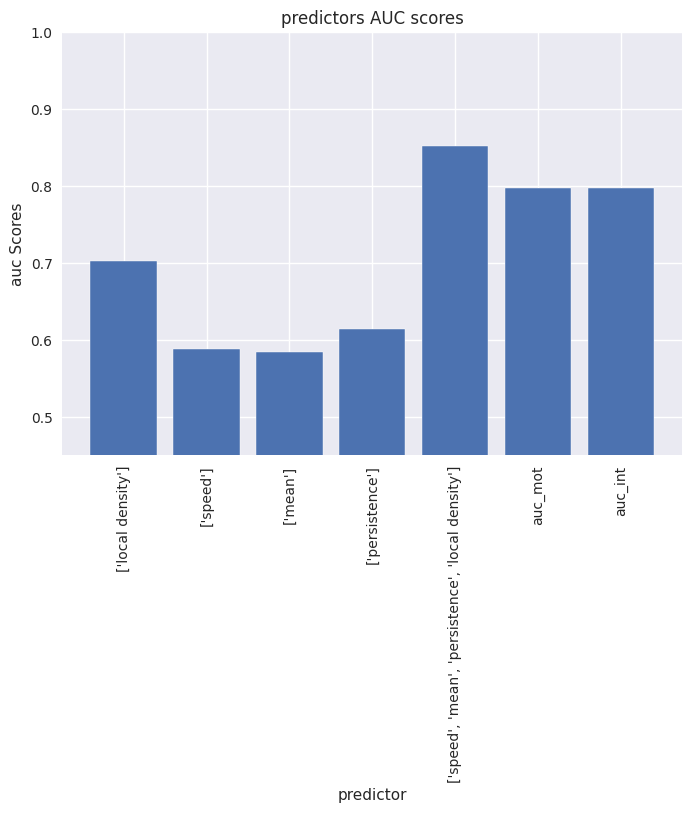

In [268]:
def get_mean_auc(model_path1, model_path2):
    clf, _, x_test, _, y_test = data_utils.load_data(model_path1, load_clf=True, load_x_train=False, load_x_test=True, load_y_test=True, load_y_train=False)
    pred = clf.predict(x_test[clf.feature_names_in_])
    fpr, tpr, thresholds = roc_curve(y_test["target"], pred, pos_label=1)
    auc1 = round(metrics.auc(fpr, tpr), 3)
    
    clf, _, x_test, _, y_test = data_utils.load_data(model_path2, load_clf=True, load_x_train=False, load_x_test=True, load_y_test=True, load_y_train=False)
    pred = clf.predict(x_test[clf.feature_names_in_])
    fpr, tpr, thresholds = roc_curve(y_test["target"], pred, pos_label=1)
    auc2 = round(metrics.auc(fpr, tpr), 3)
    
    return np.mean([auc1, auc2]), np.std([auc1, auc2])

path_mot_1 = consts.motility_model_path % (1,5)
path_mot_2 = consts.motility_model_path % (2,3)
mean_auc_mot, std_auc_mot = get_mean_auc(path_mot_1, path_mot_2)


path_int = consts.intensity_model_path % (1,5)
path_int = consts.intensity_model_path % (2,3)
mean_auc_int, std_auc_int = get_mean_auc(path_mot_1, path_mot_2)


aucs = aucs_none.copy()
aucs["auc_mot"] = (mean_auc_mot, std_auc_mot)
aucs["auc_int"] = (mean_auc_int, std_auc_int)

N = len(aucs)
ind = np.arange(N) 
  
xvals = np.array(list(aucs.values()))[:,0]
bar1 = plt.bar(ind, xvals)
  
plt.xlabel("predictor")
plt.ylabel('auc Scores')
plt.ylim((0.45,1))
plt.title("predictors AUC scores")

plt.savefig(consts.storage_path + f"eps_figs/simple_clfs_comaperison.eps", format="eps")
plt.xticks(ind, list(aucs.keys()),rotation = 90)
plt.show()

In [269]:
path = consts.storage_path + fr"simple_classifiers/test s2, s3 scaler=None,%s/df_prob_vid_num=s3.pkl"

scores_local_den_s3 = pickle.load(open(path % ["local density"], 'rb'))
scores_speed_s3 = pickle.load(open(path % ["speed"], 'rb')) 
scores_mean_s3 = pickle.load(open(path % ["mean"], 'rb'))  
scores_persistence_s3 = pickle.load(open(path % ["persistence"], 'rb'))  
scores_features_s3 = pickle.load(open(path % ["speed", "mean", "persistence", "local density"], 'rb'))   

df_score_dif_mot = pickle.load(open(consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl", 'rb'))  
df_score_dif_int = pickle.load(open(consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl", 'rb'))  

local density - median:  -0.09 size of data:  675
speed - median:  -0.03 size of data:  675
mean - median:  -0.15 size of data:  580
persistence - median:  0.19 size of data:  631
featurs - median:  -0.11 size of data:  530
motility - median:  0.51 size of data:  675
intensity - median:  0.7 size of data:  675


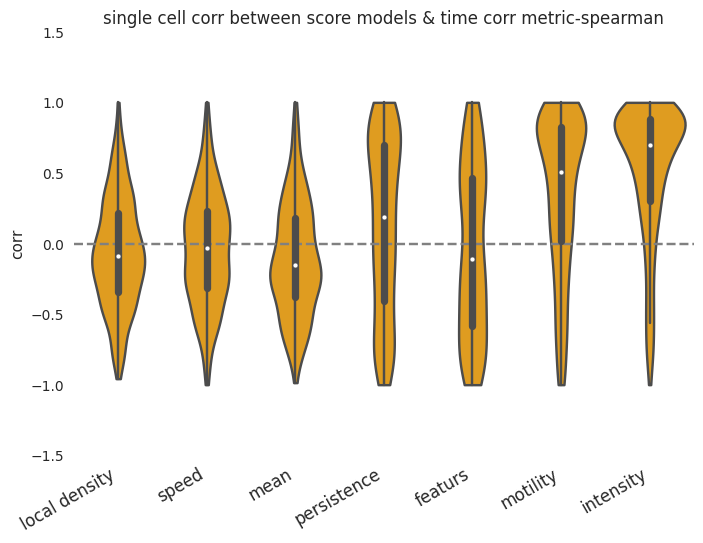

In [270]:
utils.plot_violin_spearman_corr([scores_local_den_s3, scores_speed_s3, scores_mean_s3, scores_persistence_s3, scores_features_s3, df_score_dif_mot, df_score_dif_int], 
               ["local density", "speed", "mean", "persistence", "featurs", "motility", "intensity"],
               "orange", "spearman", time=(6,13))